In [1]:
sc

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1675882034894_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-1>

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd

from pyspark.mllib.linalg.distributed import IndexedRowMatrix, IndexedRow

from pyspark.sql.functions import udf, struct
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col
import pyspark.sql.functions as f



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Create data

In [4]:
n_samples=1600
n_clusters=3
n_features =2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
np.random.seed(24)

# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)
print(Xs.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1600, 2)

In [6]:
cluster_centers_np = np.random.randn(n_clusters, n_features)
print(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[ 0.03426483  0.06039263]
 [ 0.41996483 -0.78388267]
 [ 0.25672095  1.32709177]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

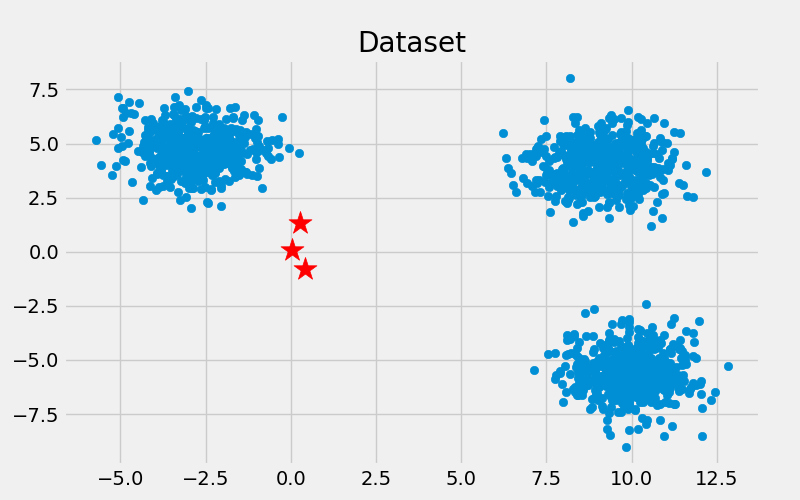

In [7]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

C= cluster_centers_np
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')

%matplot plt

In [8]:
x_df=spark.createDataFrame(pd.DataFrame(Xs,columns=list(['x1','x2'])))
x_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+
|                 x1|                 x2|
+-------------------+-------------------+
|-2.5638208798284507|  4.456735811810272|
| 10.490242243595278|-5.1535626793877345|
|-3.2685543481553845|  6.069838764259055|
| 10.435737197119435| 3.9543776746596095|
|  9.260825829214923|  4.936193706759728|
+-------------------+-------------------+
only showing top 5 rows

### KMeans updates

In [10]:
#Calculate the squared distance between a data instance and a cluster center
row = np.array(x_df.take(1)[0]) # data instance
print(np.linalg.norm(row-cluster_centers_np[0])**2) #first cluster center


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26.077882747280274

In [12]:
# calculate the squred distance between a data instance (myrow) 
#and all the cluster centers (mycenter)

def distance_from(mycenter):
    return f.udf(lambda myrow: sum([(x-mycenter[it])**2 for it,x in enumerate(myrow)]), FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
x_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+
|                 x1|                 x2|
+-------------------+-------------------+
|-2.5638208798284507|  4.456735811810272|
| 10.490242243595278|-5.1535626793877345|
|-3.2685543481553845|  6.069838764259055|
| 10.435737197119435| 3.9543776746596095|
|  9.260825829214923|  4.936193706759728|
+-------------------+-------------------+
only showing top 5 rows

In [15]:
# calculate the distances between all data points and all cluster centers
results_df =x_df
for i in np.arange(n_clusters):
    act_center=list(float(it) for it in cluster_centers_np[i])
    results_df = results_df.withColumn(f"sq_norm_{i}", distance_from(act_center)(struct([x_df[x] for x in x_df.columns])))
results_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+----------+----------+---------+
|                 x1|                 x2| sq_norm_0| sq_norm_1|sq_norm_2|
+-------------------+-------------------+----------+----------+---------+
|-2.5638208798284507|  4.456735811810272| 26.077883| 36.367058|17.750128|
| 10.490242243595278|-5.1535626793877345| 136.51279| 120.50459|146.72385|
|-3.2685543481553845|  6.069838764259055| 47.022057|  60.57867|34.921215|
| 10.435737197119435| 3.9543776746596095|123.353745| 122.76681|  110.515|
|  9.260825829214923|  4.936193706759728| 108.90286|  110.8801| 94.09952|
|-2.6294512508241956| 3.8576784451119805| 21.514763| 30.843027|14.733859|
|  7.548191177187899| -4.720251713145924|  79.31365|  66.30661|  89.7359|
|  8.555401604576748| -6.397837730270541| 114.31851|  97.70182|128.54263|
| -1.539054700017762|  4.962466533288968| 26.505663| 36.858288| 16.44076|
|-3.6051237450575684|  4.119242333215236|  29.71941| 40.241974| 22.70995|
|  9.906711684149462| -4.3393349501641

In [16]:
# select the distance columns only
sq_norms_df=results_df.select([f"sq_norm_{i}" for i in np.arange(n_clusters)])
sq_norms_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+---------+
| sq_norm_0| sq_norm_1|sq_norm_2|
+----------+----------+---------+
| 26.077883| 36.367058|17.750128|
| 136.51279| 120.50459|146.72385|
| 47.022057|  60.57867|34.921215|
|123.353745| 122.76681|  110.515|
| 108.90286|  110.8801| 94.09952|
| 21.514763| 30.843027|14.733859|
|  79.31365|  66.30661|  89.7359|
| 114.31851|  97.70182|128.54263|
| 26.505663| 36.858288| 16.44076|
|  29.71941| 40.241974| 22.70995|
| 116.82281| 102.63961|125.23071|
| 106.38139| 105.10934| 95.53321|
|  83.10985|   71.1002| 90.83209|
| 139.80429| 122.95661|151.49565|
| 134.19753| 115.93201|149.97139|
| 27.915602|  38.35228| 20.30717|
| 158.72804| 159.96434|141.59529|
|  95.80879|  98.15418|81.551125|
|  30.34465| 41.325397| 21.60421|
| 105.08262|104.946434| 92.95659|
+----------+----------+---------+
only showing top 20 rows

In [17]:
# Calculate which cluster center is the closest
@udf(returnType=IntegerType()) 
def min_dist(myrow):
    dist=int(np.argmin(np.array([x for x in myrow])))
    return dist

results_df = results_df.withColumn("min_dist", min_dist(struct([sq_norms_df[x] for x in sq_norms_df.columns])))
results_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+----------+----------+---------+--------+
|                 x1|                 x2| sq_norm_0| sq_norm_1|sq_norm_2|min_dist|
+-------------------+-------------------+----------+----------+---------+--------+
|-2.5638208798284507|  4.456735811810272| 26.077883| 36.367058|17.750128|       2|
| 10.490242243595278|-5.1535626793877345| 136.51279| 120.50459|146.72385|       1|
|-3.2685543481553845|  6.069838764259055| 47.022057|  60.57867|34.921215|       2|
| 10.435737197119435| 3.9543776746596095|123.353745| 122.76681|  110.515|       2|
|  9.260825829214923|  4.936193706759728| 108.90286|  110.8801| 94.09952|       2|
|-2.6294512508241956| 3.8576784451119805| 21.514763| 30.843027|14.733859|       2|
|  7.548191177187899| -4.720251713145924|  79.31365|  66.30661|  89.7359|       1|
|  8.555401604576748| -6.397837730270541| 114.31851|  97.70182|128.54263|       1|
| -1.539054700017762|  4.962466533288968| 26.505663| 36.858288| 16.44076|       2|
|-3.

In [22]:
# filter those instances who belong to a cluster with id cluster_id

column_names = [f'x{i}' for i in np.arange(1,n_features+1)]
#print(column_names)

cluster_id =1
selected_rows_df=results_df.filter(results_df.min_dist == cluster_id).select(column_names)
selected_rows_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-------------------+
|                x1|                 x2|
+------------------+-------------------+
|10.490242243595278|-5.1535626793877345|
| 7.548191177187899| -4.720251713145924|
| 8.555401604576748| -6.397837730270541|
| 9.906711684149462| -4.339334950164115|
| 8.299371136472597|-3.7864067258709047|
|10.352422903480027| -5.713678617112796|
| 9.132115006972672| -7.110844647008607|
|12.040196540107363| -6.556482502250076|
|  9.93089416500604| -8.226103353890947|
|  9.04334519122285| -6.759914416157469|
|11.846920458660556| -4.186623275828181|
| 8.391513726068009| -5.332233415335716|
|  8.36744622681324| -6.330335706576502|
|  9.87241181771912| -6.152802235756552|
|11.102807476705713| -5.240322848610395|
| 8.639683547898269|-5.0501399300046454|
|11.905626363505036| -4.924753016967367|
|12.324947277983334| -6.862074909447875|
|  9.85787681745546| -5.993118380123434|
|10.833422119518787| -7.023655928078864|
+------------------+-------------------+
only showing top

In [23]:
from pyspark.sql.functions import mean

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
#calculate the mean of the selected rows
selected_rows_df.select([mean('x1'),mean('x2')]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------------+
|          avg(x1)|           avg(x2)|
+-----------------+------------------+
|9.928639831102268|-5.603128892187697|
+-----------------+------------------+

In [25]:
mylist = [ mean(it) for it in column_names]
mylist

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Column<'avg(x1)'>, Column<'avg(x2)'>]

In [26]:
np.squeeze(np.array(selected_rows_df.select(mylist).collect()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([ 9.92863983, -5.60312889])

## Everything Together In a Loop

In [32]:
np.random.seed(23)
cluster_centers_np = np.random.randn(n_clusters, n_features)
print(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[ 0.66698806  0.02581308]
 [-0.77761941  0.94863382]
 [ 0.70167179 -1.05108156]]

In [36]:
x_column_names = [f'x{i}' for i in np.arange(1,n_features+1)]
x_column_mean_list = [ mean(it) for it in column_names]
print(x_column_mean_list)
cluster_centers_hist = []
cluster_centers_hist.append(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Column<'avg(x1)'>, Column<'avg(x2)'>]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

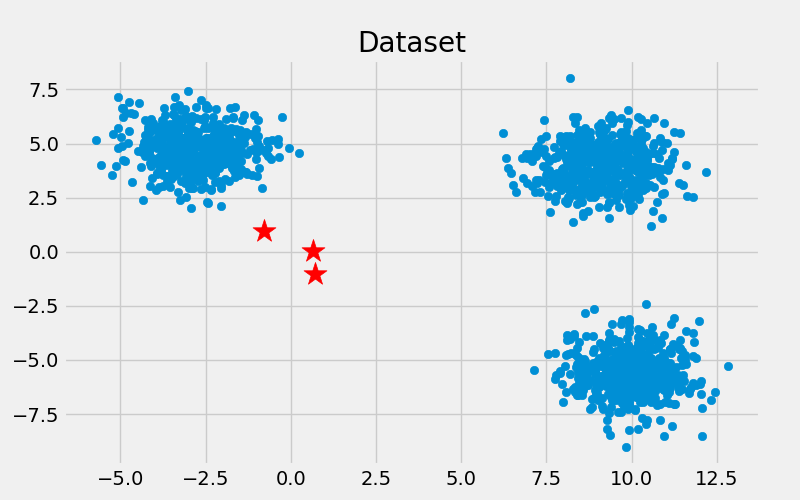

In [37]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

C= cluster_centers_hist[-1]
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')
%matplot plt

In [38]:
em_iter_num = 5

for emiter in np.arange(em_iter_num):
    #print(cluster_centers_np)
    results_df =x_df

    for i in np.arange(n_clusters):
        act_center=list(float(it) for it in cluster_centers_np[i])
        results_df = results_df.withColumn(f"sq_norm_{i}", distance_from(act_center)(struct([x_df[x] for x in x_df.columns])))
    #results_df.show()

    sq_norms_df=results_df.select([f"sq_norm_{i}" for i in np.arange(n_clusters)])
    #sq_norms_df.show()

    results_df = results_df.withColumn("min_dist", min_dist(struct([sq_norms_df[x] for x in sq_norms_df.columns])))
    #results_df.show()


    new_means=[]
    for it in range(n_clusters):
        selected_rows_df=results_df.filter(results_df.min_dist == it).select(x_column_names)
        #selecte=[]d_rows_df.show()
        new_means.append(np.squeeze(np.array(selected_rows_df.select(x_column_mean_list).collect())))
        
        #print(new_means)

    for it in range(n_clusters):
        try:
            _ = np.sum(new_means[it]) #check if the list is not none
            cluster_centers_np[it] = new_means[it]
        except:
            pass

    cluster_centers_hist.append(cluster_centers_np)
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

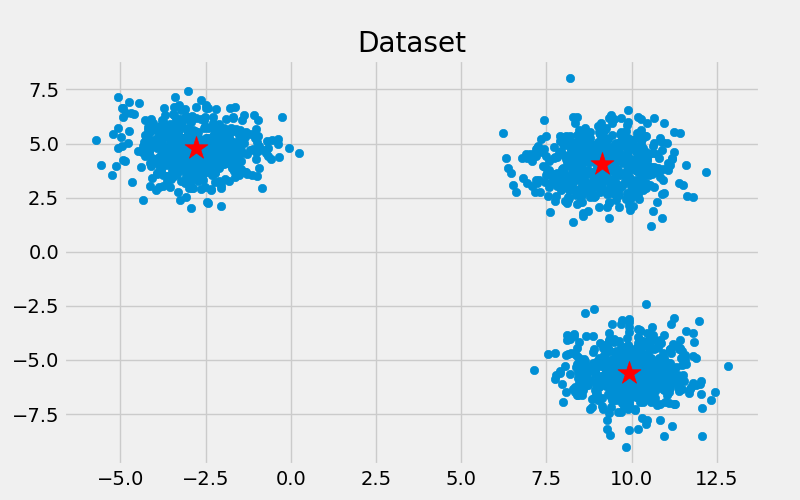

In [39]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

C= cluster_centers_hist[-1]
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')
%matplot plt